In [1]:
import pyNUISANCE as pn
import numpy as np
import pyProSelecta as pps
import pyNuHepMC as nhm
import matplotlib.pyplot as plt
import scipy

# Fetch the HepData Submission YAML

In [2]:
recordid=1713531371
resource_context = { "reftype": "hepdata-sandbox", "recordid": recordid }
submission_path = pn.hepdata.get_local_path_to_resource("", **resource_context)
print(submission_path)

/root/software/NUISANCEMC/eventinput/build/Linux/share/recorddb/hepdata-sandbox/1713531371/HEPData-1713531371-v1


In [3]:
tables = pn.hepdata.get_tables(submission_path)

for x in tables.keys():
    print(x)

cross_section-offaxis
cross_section-onaxis
covariance-onoffaxis
cross_section-onoffaxis
flux-onaxis-nominal-fine
flux-onaxis-nominal-coarse
flux-onaxis-postfit-fine
flux-onaxis-postfit-coarse
flux-offaxis-nominal-fine
flux-offaxis-nominal-coarse
flux-offaxis-postfit-fine
flux-offaxis-postfit-coarse


In [4]:
def measurement_details(table_name):
    quals = pn.hepdata.get_qualifiers(tables[table_name])
    print("Measurement: %s" % table_name)
    print("  Target: %s" % quals["target"])
    print("  Probe Species: %s" % quals["probe_species"])
    print("  Probe Spectrum: %s" % quals["probe_spectrum"])
    print("  Independent Variables: %s" % pn.hepdata.get_independent_variables(tables[table_name]))
    print("  Dependent Variables: %s" % pn.hepdata.get_dependent_variables(tables[table_name]))
    return quals

onax_quals = measurement_details("cross_section-onaxis")
offax_quals = measurement_details("cross_section-offaxis")

onax_doc = tables["cross_section-onaxis"]
offax_doc = tables["cross_section-offaxis"]

Measurement: cross_section-onaxis
  Target: CH
  Probe Species: numu
  Probe Spectrum: flux-onaxis-postfit-coarse
  Independent Variables: ['cos_theta_mu', 'p_mu']
  Dependent Variables: ['cross_section', 'cross_section_neut-prediction']
Measurement: cross_section-offaxis
  Target: CH
  Probe Species: numu
  Probe Spectrum: flux-offaxis-postfit-coarse
  Independent Variables: ['cos_theta_mu', 'p_mu']
  Dependent Variables: ['cross_section', 'cross_section_neut-prediction']


# Fluxes

In [5]:
onax_flux = pn.hepdata.make_BinnedValues(pn.hepdata.get_referenced_table(onax_quals["probe_spectrum"], **resource_context))
offax_flux = pn.hepdata.make_BinnedValues(pn.hepdata.get_referenced_table(offax_quals["probe_spectrum"], **resource_context))

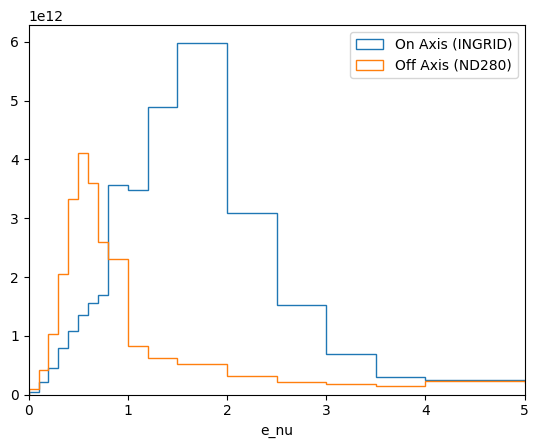

In [6]:
onax_flux.mpl().hist(label="On Axis (INGRID)", histtype="step")
offax_flux.mpl().hist(label="Off Axis (ND280)", histtype="step")

plt.xlim([0,5])

plt.legend()
plt.show()

In [7]:
#we can't use pyROOT as it currently breaks the NUSIANCE bindings (only in Jupyter though, not when executed directly in python)
pn.convert.ROOT.DumpTH1s("PRD108.fluxes.root", [ ["on_axis_flux", onax_flux ], ["off_axis_flux", offax_flux ] ])

# Generate some events

Now you will have to generate some event files with these fluxes. If you have access to the NUISANCE2 CLI (to be ported), you might run

```bash
nuis gen NEUT -f PRD108.fluxes.root,on_axis_flux -n 200000 -p numu -t CH -o onaxis.CH.neutvect.root
nuis gen NEUT -f PRD108.fluxes.root,off_axis_flux -n 200000 -p numu -t CH -o offaxis.CH.neutvect.root
```

In [8]:
#get input streams for the NEUT files (this object transparently reads NEUT, GENIE, NuWro, NuHepMC, and NUISANCE2FlatTree inputs)
evs_onax = pn.EventSource("onaxis.CH.neutvect.root")
if not evs_onax:
    print("Error: failed to open input file")

evs_offax = pn.EventSource("offaxis.CH.neutvect.root")
if not evs_offax:
    print("Error: failed to open input file")

# Cross Sections

In [9]:
analysis_path = pn.hepdata.get_local_path_to_resource("analysis.cxx", **resource_context)
pps.load_file(analysis_path)
print(analysis_path)

/root/software/NUISANCEMC/eventinput/build/Linux/share/recorddb/hepdata-sandbox/1713531371/HEPData-1713531371-v1/analysis.cxx


In [10]:
onax_sel = pn.hepdata.get_selection_function(onax_doc)
onax_proj_names, onax_proj_funcs = pn.hepdata.get_projection_functions(onax_doc)
print(onax_proj_names)

offax_sel = pn.hepdata.get_selection_function(offax_doc)
offax_proj_names, offax_proj_funcs = pn.hepdata.get_projection_functions(offax_doc)
print(offax_proj_names)

['T2K_CC0Pi_onoffaxis_nu_Project_CosThetaMu', 'T2K_CC0Pi_onoffaxis_nu_Project_PMu']
['T2K_CC0Pi_onoffaxis_nu_Project_CosThetaMu', 'T2K_CC0Pi_onoffaxis_nu_Project_PMu']


In [11]:
# build data frames from the input files, events that fail the selection do not
#  produce rows in the data frame. Columns are populated with the projection
#  functions that we JIT'd from the analysis.cxx
fg_onax = pn.EventFrameGen(evs_onax).filter(onax_sel[1])
for fn,f in zip(onax_proj_names, onax_proj_funcs):
    fg_onax.add_column(fn, f)

fg_offax = pn.EventFrameGen(evs_offax).filter(offax_sel[1])
for fn,f in zip(offax_proj_names, offax_proj_funcs):
    fg_offax.add_column(fn, f)

In [12]:
ef_onax = fg_onax.firstArrow(int(1E6))
ef_offax = fg_offax.firstArrow(int(1E6))

In [13]:
ef_onax.to_pandas()

,event.number,weight.cv,process.id,fatx.estimate,T2K_CC0Pi_onoffaxis_nu_Project_CosThetaMu,T2K_CC0Pi_onoffaxis_nu_Project_PMu
0,0,1.0,300,0.208923,0.903811,0.801447
1,5,1.0,200,0.208923,0.993001,0.717699
2,7,1.0,200,0.208923,0.946144,1.470697
3,11,1.0,400,0.208923,-0.053326,0.512122
4,15,1.0,300,0.208923,0.598236,0.670515
...,...,...,...,...,...,...
170789,499988,1.0,200,0.208923,0.911077,0.879853
170790,499991,1.0,200,0.208923,0.904648,1.168153
170791,499993,1.0,200,0.208923,0.783408,1.148813
170792,499998,1.0,401,0.208923,0.833715,0.759196


In [14]:
import polars as pl
pl_df = pl.from_arrow(ef_onax)
pl_df

event.number,weight.cv,process.id,fatx.estimate,T2K_CC0Pi_onoffaxis_nu_Project_CosThetaMu,T2K_CC0Pi_onoffaxis_nu_Project_PMu
i64,f64,i64,f64,f64,f64
0,1.0,300,0.208923,0.903811,0.801447
5,1.0,200,0.208923,0.993001,0.717699
7,1.0,200,0.208923,0.946144,1.470697
11,1.0,400,0.208923,-0.053326,0.512122
15,1.0,300,0.208923,0.598236,0.670515
…,…,…,…,…,…
499988,1.0,200,0.208923,0.911077,0.879853
499991,1.0,200,0.208923,0.904648,1.168153
499993,1.0,200,0.208923,0.783408,1.148813


In [15]:
onax_data = pn.hepdata.make_BinnedValues(onax_doc)
offax_data = pn.hepdata.make_BinnedValues(offax_doc)

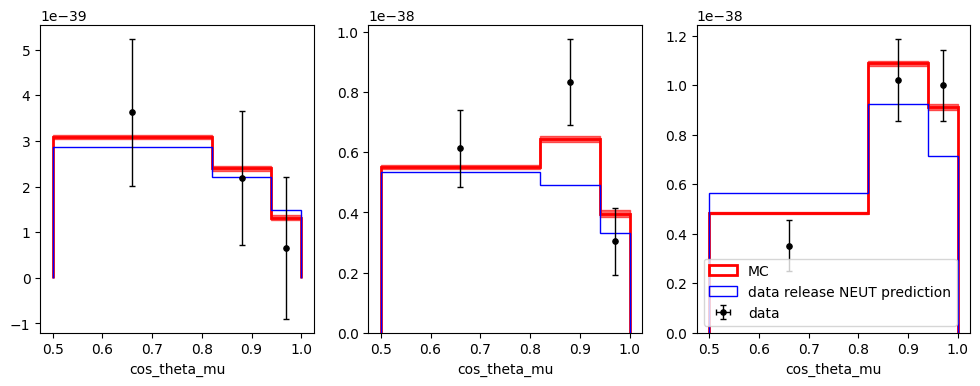

In [16]:
ctheta_bins = onax_data.project(1).binning.bins

#make a fillable histogram from the data
onax_mc = onax_data.make_HistFrame()
onax_mc.fill_from_Arrow(ef_onax, onax_proj_names)

#fatx is in pb/A, -> 1pb is 10^-36 want /12 to take it back to the /N from the generator
sf = fg_onax.norm_info().fatx_per_sumweights() * (1E-36) /12

#scale it to the right units
onax_mc.sumweights = onax_mc.sumweights * sf
onax_mc.variances = onax_mc.variances * (sf**2)

onax_pred = onax_mc.finalise(True)

fig, axes = plt.subplots(1,3, figsize=(12,4))

for i,ax in enumerate(axes):
    xsl_pred = onax_pred.slice(1, ctheta_bins[i][0].low)
    xsl_data = onax_data.slice(1, ctheta_bins[i][0].low)

    #remove overflow bin if its not the only bin
    xsl_pred = xsl_pred.slice(0,[0,1],True)
    xsl_data = xsl_data.slice(0,[0,1],True)
    
    xsl_pred.mpl().hist(plot_axis=ax, color="#F00", histtype="step", linewidth=2, errorband_color="#F009", label="MC")
    xsl_data.mpl().hist(plot_axis=ax, color="#00F", label="data release NEUT prediction", column="cross_section_neut-prediction", histtype="step")
    xsl_data.mpl().errorbar(plot_axis=ax, marker=".", markersize=7.5, color="#000", label="data", linewidth=0, elinewidth=1, capsize=2.5)
    
ax.legend()
fig.show()

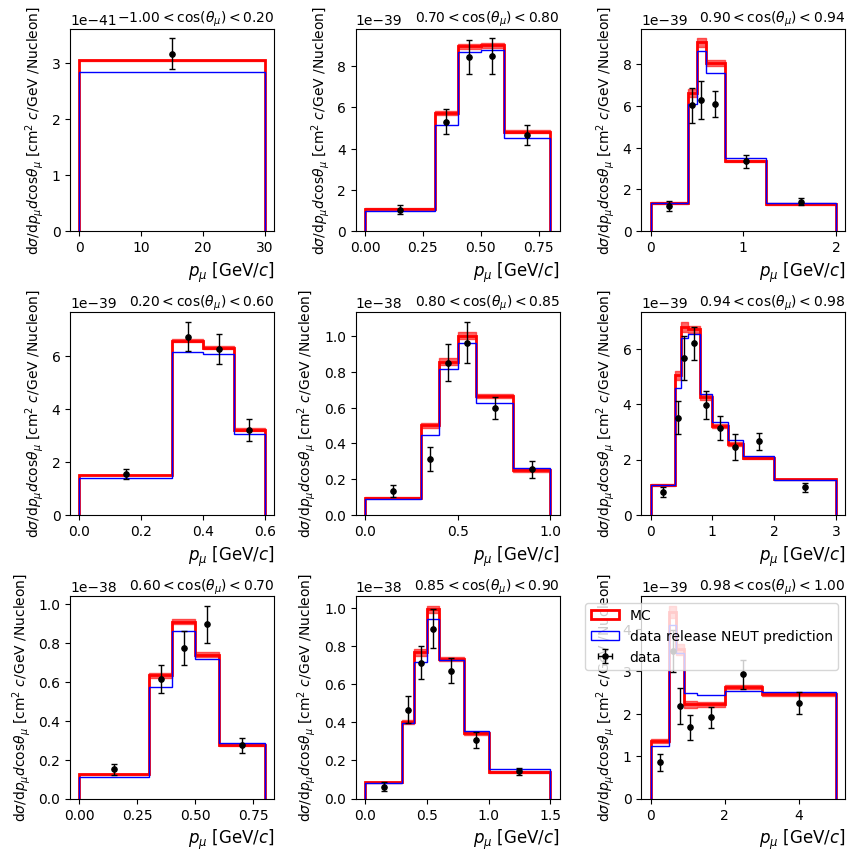

In [17]:
ctheta_bins = offax_data.project(0).binning.bins

#make a fillable histogram from the data
offax_mc = offax_data.make_HistFrame()
offax_mc.fill_from_Arrow(ef_offax, offax_proj_names)

#fatx is in pb/A, -> 1pb is 10^-36 want /12 to take it back to the /N from the generator
sf = fg_offax.norm_info().fatx_per_sumweights() * (1E-36) /12

#scale it to the right units
offax_mc.sumweights = offax_mc.sumweights * sf
offax_mc.variances = offax_mc.variances * (sf**2)

offax_pred = offax_mc.finalise(True)

fig, axes = plt.subplots(3,3, figsize=(10,10), gridspec_kw={"hspace":0.4,"wspace":0.4})

for i in range(len(ctheta_bins)):
    ax = axes[i%3,i//3]
    xsl_data = offax_data.slice(0, ctheta_bins[i][0].low)
    xsl_pred = offax_pred.slice(0, ctheta_bins[i][0].low)

    #remove overflow bin if its not the only bin
    if len(xsl_data.binning.bins) > 1:
        xsl_data = xsl_data.slice(0,[0,5],True)
        xsl_pred = xsl_pred.slice(0,[0,5],True)
        
    xsl_pred.mpl().hist(plot_axis=ax, color="#F00", histtype="step", linewidth=2, errorband_color="#F009", label="MC")
    xsl_data.mpl().hist(plot_axis=ax, color="#00F", label="data release NEUT prediction", column="cross_section_neut-prediction", histtype="step")
    xsl_data.mpl().errorbar(plot_axis=ax, marker=".", markersize=7.5, color="#000", label="data", linewidth=0, elinewidth=1, capsize=2.5)
    ax.set_xlabel(r"$p_\mu$ [GeV/$c$]", loc="right", fontsize="large")
    ax.set_ylabel(r"$\text{d}\sigma/\text{d}p_{\mu}d\text{cos}\theta_\mu\ [\text{cm}^{2}\ c/\text{GeV}\ /\text{Nucleon}]$", fontsize="medium")
    ax.tick_params(axis='x', labelsize="medium")
    ax.tick_params(axis='y', labelsize="medium")

    ax.text(1, 1.03, r"$%.2f < \text{cos}(\theta_\mu) < %.2f$" % (ctheta_bins[i][0].low,ctheta_bins[i][0].high), 
            horizontalalignment="right", transform=ax.transAxes, fontsize="medium")
    
plt.legend()
plt.show()

In [18]:
joint_doc = tables["cross_section-onoffaxis"]
#get sub measurements
joint_measurements = pn.hepdata.get_sub_measurement_tables(joint_doc, **resource_context)
joint_covar = pn.hepdata.get_covariance(joint_doc, **resource_context)

In [19]:
def calc_chisq(h_data, h_mc, h_invcov):

    #Calculate the difference between data and MC and transform into a column vector
    diff = (h_data - h_mc).reshape(1, -1)

    #Use vector/matrix multiplication to calculate chi-square
    chisq = diff @ h_invcov @ diff.T
    return chisq.item()

In [20]:
#combine the off/on axis predictions
offonax_pred = np.append(offax_pred.values[:,0],onax_pred.values[:,0])
offonax_data = np.append(offax_data.values[:,0],onax_data.values[:,0])
offonax_neut_pred = np.append(offax_data.values[:,1],onax_data.values[:,1])

In [22]:
print("chi2 = %s" % calc_chisq(offonax_data, offonax_pred, np.linalg.inv(joint_covar) ))

chi2 = 147.87946021405818


In [23]:
print("chi2 w/release pred = %s" % calc_chisq(offonax_data, offonax_neut_pred, np.linalg.inv(joint_covar) ))

chi2 w/release pred = 158.7236165628163
